# Business Objective
Let us assume you went to amazon website and you selected a t-shirt, now you want to see the t-shirts which are very similar to your selected t-shirt. You have to build a recommendation system which gives 10 to 20 similar products from the product you selected.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import os, math, nltk, re, requests, pickle
from collections import Counter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise_distances
import pickle

In [2]:
# importing the json file
data = pd.read_json("C:/Users/HP/Desktop/Study Material/AI_Project/Product_Recommendation_System/data_folder/tops_fashion.json")
data.head()

,sku,asin,product_type_name,formatted_price,author,color,brand,publisher,availability,reviews,large_image_url,availability_type,small_image_url,editorial_review,title,model,medium_image_url,manufacturer,editorial_reivew
0,None,B016I2TS4W,SHIRT,None,None,None,FNC7C,None,None,"[False, https://www.amazon.com/reviews/iframe?...",https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,Minions Como Superheroes Ironman Women's O Nec...,Minions Como Superheroes Ironman Long Sleeve R...,None,https://images-na.ssl-images-amazon.com/images...,None,NaN
1,None,B01N49AI08,SHIRT,None,None,None,FIG Clothing,None,None,"[False, https://www.amazon.com/reviews/iframe?...",https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,Sizing runs on the small side. FIG® recommends...,FIG Clothing Womens Izo Tunic,None,https://images-na.ssl-images-amazon.com/images...,None,NaN
2,None,B01JDPCOHO,SHIRT,None,None,None,FIG Clothing,None,None,"[False, https://www.amazon.com/reviews/iframe?...",https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,Sizing runs on the small side. FIG® recommends...,FIG Clothing Womens Won Top,None,https://images-na.ssl-images-amazon.com/images...,None,NaN
3,None,B01N19U5H5,SHIRT,None,None,None,Focal18,None,None,"[True, https://www.amazon.com/reviews/iframe?a...",https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,100% Brand New & Fashion<br> Quantity: 1 Piece...,Focal18 Sailor Collar Bubble Sleeve Blouse Shi...,None,https://images-na.ssl-images-amazon.com/images...,None,NaN
4,None,B004GSI2OS,SHIRT,$26.26,None,Onyx Black/ Stone,FeatherLite,None,Usually ships in 6-10 business days,"[False, https://www.amazon.com/reviews/iframe?...",https://images-na.ssl-images-amazon.com/images...,now,https://images-na.ssl-images-amazon.com/images...,,Featherlite Ladies' Long Sleeve Stain Resistan...,None,https://images-na.ssl-images-amazon.com/images...,None,NaN


In [3]:
# checking the columns present in Data
data.columns

Index(['sku', 'asin', 'product_type_name', 'formatted_price', 'author',
       'color', 'brand', 'publisher', 'availability', 'reviews',
       'large_image_url', 'availability_type', 'small_image_url',
       'editorial_review', 'title', 'model', 'medium_image_url',
       'manufacturer', 'editorial_reivew'],
      dtype='object')

In [4]:
# Checking the shape of Data
data.shape

(183138, 19)

In [5]:
# Here we wont be using all the available features
# here we will be using the 7 features out of the total available features

data = data[["asin","brand","color","medium_image_url","product_type_name","title","formatted_price"]]
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
0,B016I2TS4W,FNC7C,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,Minions Como Superheroes Ironman Long Sleeve R...,None
1,B01N49AI08,FIG Clothing,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,FIG Clothing Womens Izo Tunic,None
2,B01JDPCOHO,FIG Clothing,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,FIG Clothing Womens Won Top,None
3,B01N19U5H5,Focal18,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,Focal18 Sailor Collar Bubble Sleeve Blouse Shi...,None
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,Featherlite Ladies' Long Sleeve Stain Resistan...,$26.26


In [6]:
# now we will check how may unique product_type_name we have in our data
data["product_type_name"].unique()

array(['SHIRT', 'SWEATER', 'APPAREL', 'OUTDOOR_RECREATION_PRODUCT',
       'BOOKS_1973_AND_LATER', 'PANTS', 'HAT', 'SPORTING_GOODS', 'DRESS',
       'UNDERWEAR', 'SKIRT', 'OUTERWEAR', 'BRA', 'ACCESSORY',
       'ART_SUPPLIES', 'SLEEPWEAR', 'ORCA_SHIRT', 'HANDBAG',
       'PET_SUPPLIES', 'SHOES', 'KITCHEN', 'ADULT_COSTUME',
       'HOME_BED_AND_BATH', 'MISC_OTHER', 'BLAZER',
       'HEALTH_PERSONAL_CARE', 'TOYS_AND_GAMES', 'SWIMWEAR',
       'CONSUMER_ELECTRONICS', 'SHORTS', 'HOME', 'AUTO_PART',
       'OFFICE_PRODUCTS', 'ETHNIC_WEAR', 'BEAUTY',
       'INSTRUMENT_PARTS_AND_ACCESSORIES', 'POWERSPORTS_PROTECTIVE_GEAR',
       'SHIRTS', 'ABIS_APPAREL', 'AUTO_ACCESSORY', 'NONAPPARELMISC',
       'TOOLS', 'BABY_PRODUCT', 'SOCKSHOSIERY',
       'POWERSPORTS_RIDING_SHIRT', 'EYEWEAR', 'SUIT', 'OUTDOOR_LIVING',
       'POWERSPORTS_RIDING_JACKET', 'HARDWARE', 'SAFETY_SUPPLY',
       'ABIS_DVD', 'VIDEO_DVD', 'GOLF_CLUB', 'MUSIC_POPULAR_VINYL',
       'HOME_FURNITURE_AND_DECOR', 'TABLET_COMPUTER',

In [7]:
# details of the product_type_name feature
data["product_type_name"].describe()

count     183138
unique        72
top        SHIRT
freq      167794
Name: product_type_name, dtype: object

In [8]:
# now we will see in the given 72 product_type_name how much quantity of products are present
product_list = Counter(data["product_type_name"])
product_list

Counter({'SHIRT': 167794,
         'SWEATER': 837,
         'APPAREL': 3549,
         'OUTDOOR_RECREATION_PRODUCT': 729,
         'BOOKS_1973_AND_LATER': 3336,
         'PANTS': 363,
         'HAT': 18,
         'SPORTING_GOODS': 1281,
         'DRESS': 1584,
         'UNDERWEAR': 425,
         'SKIRT': 107,
         'OUTERWEAR': 796,
         'BRA': 95,
         'ACCESSORY': 636,
         'ART_SUPPLIES': 17,
         'SLEEPWEAR': 142,
         'ORCA_SHIRT': 290,
         'HANDBAG': 21,
         'PET_SUPPLIES': 2,
         'SHOES': 198,
         'KITCHEN': 46,
         'ADULT_COSTUME': 25,
         'HOME_BED_AND_BATH': 11,
         'MISC_OTHER': 62,
         'BLAZER': 249,
         'HEALTH_PERSONAL_CARE': 92,
         'TOYS_AND_GAMES': 80,
         'SWIMWEAR': 41,
         'CONSUMER_ELECTRONICS': 1,
         'SHORTS': 14,
         'HOME': 34,
         'AUTO_PART': 3,
         'OFFICE_PRODUCTS': 7,
         'ETHNIC_WEAR': 34,
         'BEAUTY': 21,
         'INSTRUMENT_PARTS_AND_ACCESSO

<Axes: >

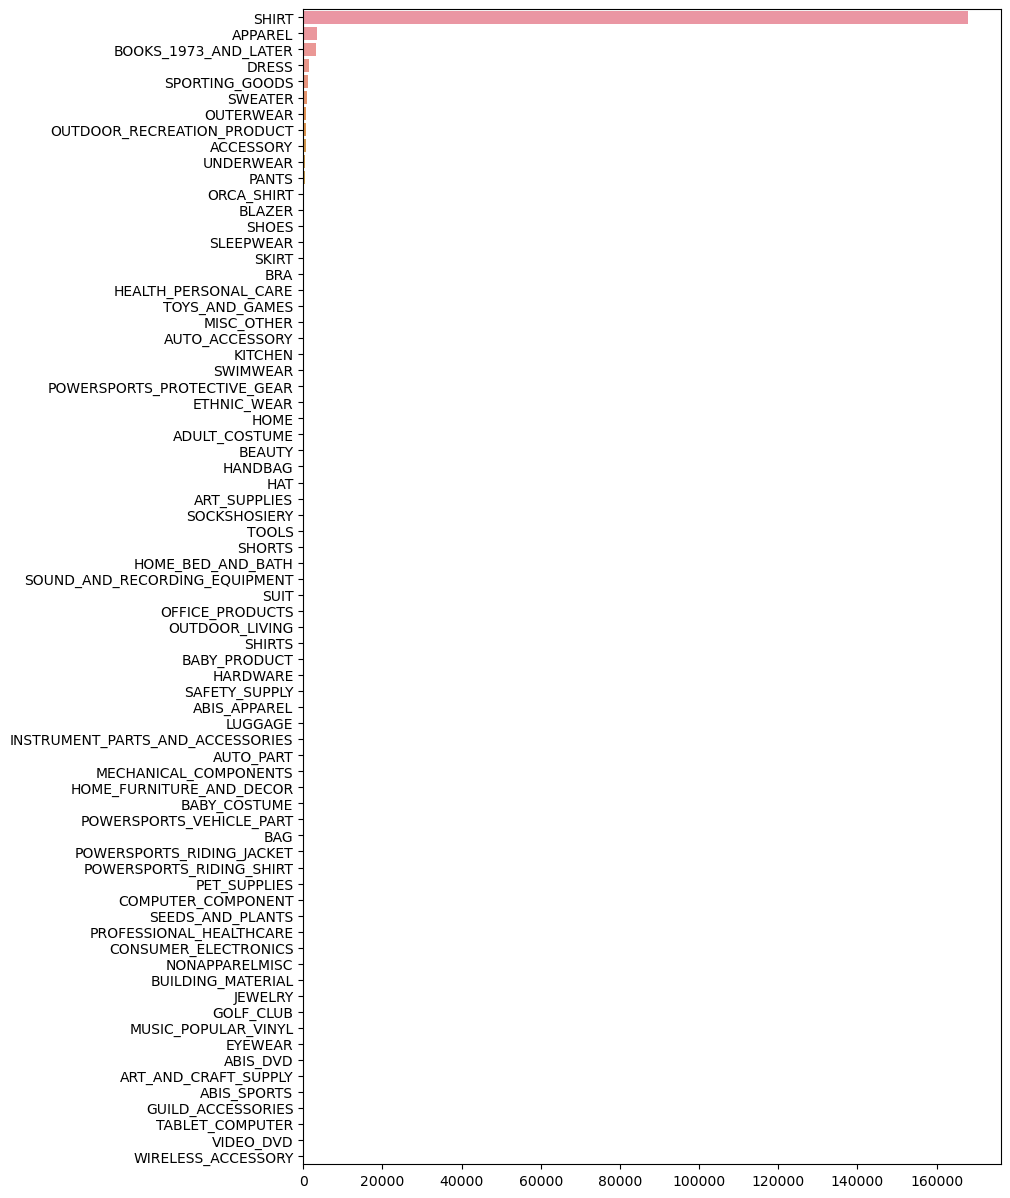

In [9]:
# plotting bar plot
product_type_name = data["product_type_name"].value_counts()
plt.figure(figsize=(9,15))
sns.barplot(x = product_type_name.values, y = product_type_name.index, orient='h')

In [10]:
# now we will see the top 10 most common products
product_list.most_common(10)

[('SHIRT', 167794),
 ('APPAREL', 3549),
 ('BOOKS_1973_AND_LATER', 3336),
 ('DRESS', 1584),
 ('SPORTING_GOODS', 1281),
 ('SWEATER', 837),
 ('OUTERWEAR', 796),
 ('OUTDOOR_RECREATION_PRODUCT', 729),
 ('ACCESSORY', 636),
 ('UNDERWEAR', 425)]

<Axes: >

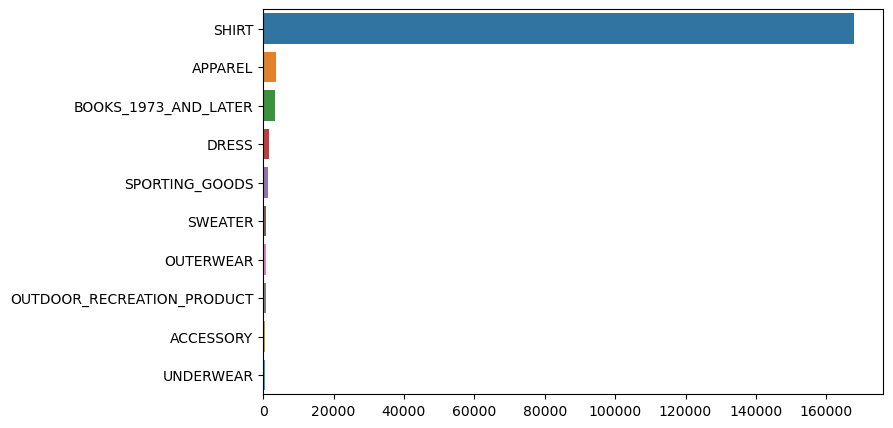

In [11]:
# plotting bar plot for top 10 most common products
product_type_name = data["product_type_name"].value_counts()
product_type_name_10 = product_type_name.head(10)
plt.figure(figsize=(8,5))
sns.barplot(x = product_type_name_10.values, y = product_type_name_10.index, orient='h')

In [12]:
# now we will check how may unique brand we have in our data
data["brand"].unique()

array(['FNC7C', 'FIG Clothing', 'Focal18', ..., 'Z', "Rain's Pan Jacket",
       'FFLMYUHULIU'], dtype=object)

In [13]:
# details of the product_type_name feature
data["brand"].describe()

count     182987
unique     10577
top         Zago
freq         223
Name: brand, dtype: object

In [14]:
# now we will see in the given 10577 brands and each brand has how many products
brand_list = Counter(data["brand"])
brand_list

Counter({'FNC7C': 63,
         'FIG Clothing': 38,
         'Focal18': 9,
         'FeatherLite': 83,
         'Fitscloth': 20,
         'HX-Kingdom Fashion T-shirts': 26,
         'Floerns': 82,
         'Fashion2ne1': 91,
         'Fila': 91,
         'Fitness Etc.': 22,
         'FIFTEEN TWENTY': 70,
         'Tee Fashion': 61,
         'Fedi Apparel': 65,
         'FEA Merchandising': 16,
         'FIFA': 96,
         'Fight Like a Girl': 64,
         'FDPlus': 59,
         'Fifth Sun': 42,
         'Fifth Parallel Threads': 68,
         'Alivila.Y Fashion': 1,
         'Fast & Furious': 12,
         'Firebo': 24,
         'Fashion Story': 86,
         'Flying Street': 75,
         'Flying Colors': 67,
         'Flawless': 5,
         'FARYSAYS': 55,
         'FISACE': 38,
         'Feel The Piece': 33,
         'Fishouflage': 5,
         'Fashionazzle': 10,
         'Fifth Degree': 42,
         'FineBrandShop': 98,
         'Fashionomics': 13,
         'FASCIINO': 53,
         'Fe

In [15]:
# now checking the 10 top brands
brand_list.most_common(10)

[('Zago', 223),
 ('XQS', 222),
 ('Yayun', 215),
 ('YUNY', 198),
 ('XiaoTianXin-women clothes', 193),
 ('Generic', 192),
 ('Boohoo', 190),
 ('Alion', 188),
 ('Abetteric', 187),
 ('TheMogan', 187)]

<Axes: >

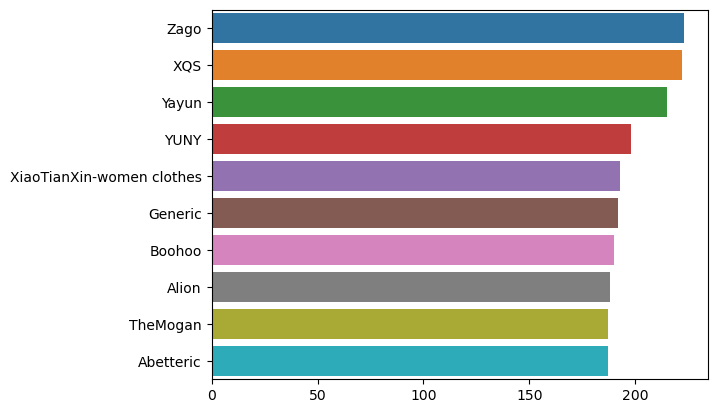

In [16]:
brand = data["brand"].value_counts()
brand_10 = brand.head(10)
sns.barplot(x = brand_10.values, y = brand_10.index)

In [17]:
# now we will check how many unique color we have in our data
data["color"].unique()

array([None, 'Onyx Black/ Stone', 'Grape', ..., 'Combo C',
       'White, Soft Coral and Charcoal Varigated', 'Monochrome Plaid'],
      dtype=object)

In [18]:
# details of the color feature
data["color"].describe()

count     64956
unique     7380
top       Black
freq      13207
Name: color, dtype: object

In [19]:
# now we will see the unique 7380 colors present in the data
color_list = Counter(data["color"])
color_list

Counter({None: 118182,
         'Onyx Black/ Stone': 2,
         'Grape': 7,
         'White': 8616,
         'Black': 13207,
         'Light': 2,
         'Grey': 1499,
         'Purple': 951,
         'Purple Heather': 13,
         'Cancun': 14,
         '*': 1388,
         'As the picture shown': 1,
         'Coral Reef': 4,
         'Green': 1258,
         'Plum': 48,
         'Royal Blue': 179,
         'Navy': 846,
         'Pacific Blue': 15,
         'Aquamarine': 5,
         'Burgandy': 10,
         'Fuchsia': 80,
         'Night Sky': 1,
         'Red': 2289,
         'Ivory': 380,
         'white': 6,
         'Burgundy': 142,
         'Alpine Purple': 6,
         'Coffee Bean': 3,
         'Blue': 3570,
         'Ftt011_mint': 1,
         'Wine': 91,
         'Eggshell': 11,
         'Heather': 13,
         'Pink': 1842,
         'Gray': 1189,
         'Crimson': 57,
         'White/Blue': 21,
         'Coral': 277,
         'Green, Dark Grey': 1,
         'Indigo': 83,
   

In [20]:
# now checking the 10 top colors
color_list.most_common(10)

[(None, 118182),
 ('Black', 13207),
 ('White', 8616),
 ('Blue', 3570),
 ('Red', 2289),
 ('Pink', 1842),
 ('Grey', 1499),
 ('*', 1388),
 ('Green', 1258),
 ('Multi', 1203)]

In [21]:
# details of the formatted_price feature
data["formatted_price"].describe()

count      28395
unique      3135
top       $19.99
freq         945
Name: formatted_price, dtype: object

In [22]:
# now we will see the unique 3135 formatted_price present in the data
formatted_price_list = Counter(data["formatted_price"])
formatted_price_list

Counter({None: 154743,
         '$26.26': 2,
         '$9.99': 749,
         '$11.99': 213,
         '$20.54': 5,
         '$7.50': 463,
         '$7.39': 9,
         '$13.53': 1,
         '$6.95': 10,
         '$7.90': 6,
         '$72.40': 1,
         '$22.78': 4,
         '$16.99': 317,
         '$88.00': 43,
         '$17.83': 1,
         '$79.20': 20,
         '$12.91': 10,
         '$34.99': 272,
         '$21.00': 20,
         '$65.00': 28,
         '$6.99': 120,
         '$9.75': 28,
         '$19.86': 2,
         '$14.97': 34,
         '$16.70': 3,
         '$15.74': 4,
         '$23.95': 35,
         '$45.99': 39,
         '$33.44': 11,
         '$22.89': 13,
         '$7.99': 137,
         '$19.99': 945,
         '$5.00': 47,
         '$8.99': 343,
         '$22.91': 4,
         '$61.60': 14,
         '$29.99': 370,
         '$28.00': 71,
         '$19.95': 114,
         '$15.10': 8,
         '$12.99': 293,
         '$4.99': 74,
         '$9.49': 147,
         '$52.99': 30,


In [23]:
# now taking a look at the top 10 formatted_price from the data
formatted_price_list.most_common(10)

[(None, 154743),
 ('$19.99', 945),
 ('$9.99', 749),
 ('$9.50', 601),
 ('$14.99', 472),
 ('$7.50', 463),
 ('$24.99', 414),
 ('$29.99', 370),
 ('$8.99', 343),
 ('$9.01', 336)]

In [24]:
# details of the title feature
data["title"].describe()

count                                                183138
unique                                               175985
top       Nakoda Cotton Self Print Straight Kurti For Women
freq                                                     77
Name: title, dtype: object

In [25]:
# checking for the duplicates in tiles
data["title"].duplicated().sum()

7153

In [26]:
# therefore we have 7153 duplicate titles

In [27]:
# now we will remove those rows which does not have price mentioned
print("Number of data points before removing the rows with formatted_price = null is: ", data.shape[0])
data = data.loc[~data["formatted_price"].isnull()]
print("Number of data points after removing the rows with formatted_price = null is: ", data.shape[0])

Number of data points before removing the rows with formatted_price = null is:  183138
Number of data points after removing the rows with formatted_price = null is:  28395


In [28]:
# now similarly we will remove those rows which does not have color mentioned
print("Number of data points before removing the rows with color = null is: ", data.shape[0])
data = data.loc[~data["color"].isnull()]
print("Number of data points after removing the rows with color = null is: ", data.shape[0])

Number of data points before removing the rows with color = null is:  28395
Number of data points after removing the rows with color = null is:  28385


In [29]:
print("The shape of the data is: ", data.shape)

The shape of the data is:  (28385, 7)


In [30]:
# Title is the very important colun for us 
# There we will remove all those rows where the title of product had words less than 4

data = data[data["title"].apply(lambda x: len(x.split())>4)]

In [31]:
# checking the shape of the data
print("The shape of the data after the removal of those titles where words where less than 4 is: ", data.shape)

The shape of the data after the removal of those titles where words where less than 4 is:  (27949, 7)


In [32]:
# now we will be arranging the titles in alphabetical order
data.sort_values("title", inplace = True, ascending = False)

In [33]:
# now we will download the stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [34]:
#now we will be using the stopwords downloaded from the nltk library
stop_words = set(stopwords.words('english'))
print("the stopwords are: ")
print(stop_words)

the stopwords are: 
{'same', 'on', "hadn't", "needn't", 'other', 'further', 'those', 'theirs', 'what', 'had', 'there', "you'd", 'have', 'and', 'am', 'll', 'the', 'how', 'such', 'be', 'a', 'who', 'nor', 'her', 'haven', 'their', 'into', 'hers', 'yourself', 'it', 'being', 'before', 't', "you're", "mustn't", 'up', 'why', 'she', 'couldn', 'weren', 'm', 'through', "she's", 'some', 'itself', 'our', 've', "doesn't", 'because', "shan't", 'mightn', 'is', 'to', 'ours', "weren't", 'here', 'been', 'most', "shouldn't", 'its', 'did', 'isn', 'more', 'wasn', 'too', 'about', 'down', 'very', 'between', 'under', 'off', 'against', 'both', 'by', "hasn't", "it's", 'again', 'when', 'were', 'doing', "couldn't", "isn't", "didn't", 'doesn', 'or', 'above', "wasn't", 'while', "you've", 're', 'are', "mightn't", 'of', 'where', 'don', 'herself', 's', 'not', 'needn', 'an', 'all', 'ain', 'y', 'didn', 'yours', 'will', 'me', 'they', 'do', 'themselves', 'if', 'few', "won't", 'than', 'should', 'now', 'was', 'with', 'has', 

In [35]:
# now we will do the preprocessing required in nlp

def nlp_preprocessing(total_text,index,column):
    if type(total_text) is not int:
        string = ""
        for words in total_text.split():
            # remove the special chars in review like '"#$@!%^&*()_+-~?>< etc.
            word = "".join(i for i in words if i.isalnum())
            # Conver all letters to lower-case
            word = word.lower()
            # stop-word removal
            if word not in stop_words:
                string += word + " "
        data[column][index] = string

In [36]:
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
61973,B06Y1KZ2WB,Éclair,Black/Pink,https://images-na.ssl-images-amazon.com/images...,SHIRT,Éclair Women's Printed Thin Strap Blouse Black...,$24.99
133820,B010RV33VE,xiaoming,Pink,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Womens Sleeveless Loose Long T-shirts...,$18.19
81461,B01DDSDLNS,xiaoming,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Women's White Long Sleeve Single Brea...,$21.58
75995,B00X5LYO9Y,xiaoming,Red Anchors,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Stripes Tank Patch/Bear Sleeve Anchor...,$15.91
151570,B00WPJG35K,xiaoming,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Sleeve Sheer Loose Tassel Kimono Woma...,$14.32


# BAG OF WORDS

In [37]:
# creating object for the CountVectorizer
# which is used to convert text data into a matrix of token counts.
title_vectorizer = CountVectorizer()
# here the vectors are formed for each title present in data and it is stored in a variable naming title_features
title_features = title_vectorizer.fit_transform(data["title"])
title_features.get_shape()

# title_features contains a matrix where each row represents a title, & each title is represented by a vector of token counts. 
# This matrix is commonly used as input to machine learning algorithms for tasks such as text classification.

(27949, 11681)

In [38]:
# now we have 27949 rows in total and we want to find the similar product based on the selected product then for that 
# we will write the following function

def bag_of_words_model(doc_id, num_of_results):
    pairwise_distance = pairwise_distances(title_features, title_features[doc_id])
    # Calculates the pairwise distances between the vector representation of the input document and all other documents 
    # in the corpus using cosine distance formula
    
    indices = np.argsort(pairwise_distance.flatten())[0:num_of_results]
    # Sorts the pairwise distances in ascending order and returns indices of the smallest distances
    
    pdists = np.sort(pairwise_distance.flatten())[0:num_of_results]
    # Stores the smallest distances
    
    df_indices = list(data.index[indices])
    # Dataframe indices of the smallest distances
    
    for i in range(len(indices)):
        # Passes 1. doc_id, 2. title1, 3. title2, URL, and model
        print('ASIN :', data['asin'].loc[df_indices[i]])
        print('Brand:', data['brand'].loc[df_indices[i]])
        print('Title:', data['title'].loc[df_indices[i]])
        print('Cosine similarity with the query point:', pdists[i])
        print('='*60)

        
    #indices[i]:                                  The index of the similar product in the original dataset.
    #data['title'].loc[df_indices[0]]:            The title of the input document (query point).
    #data['title'].loc[df_indices[i]]:            The title of the similar product.
    #data['medium_image_url'].loc[df_indices[i]]: The URL of the image of the similar product.
    #'bag_of_words':                              The model type used for similarity calculation.

In [39]:
#call the bag-of-words model for a product to get similar products.
bag_of_words_model(932, 10) 

ASIN : B072P6B7XY
Brand: Xhilaration
Title: Xhilaration Women's Flowy Peasant Tie Neck Blouse, Medium, Teal/Red Floral
Cosine similarity with the query point: 0.0
ASIN : B06Y6G64R4
Brand: Xhilaration
Title: Xhilaration Women's Floral Blouse, Ivory Spring, Medium
Cosine similarity with the query point: 2.8284271247461903
ASIN : B06ZZ2FRSB
Brand: Xhilaration
Title: Xhilaration Women's Blouse, Black, Medium
Cosine similarity with the query point: 2.8284271247461903
ASIN : B01KN10R4O
Brand: tommy hilfinger
Title: Tommy Hilfiger Women's V-neck Tunic Blouse - Red/ Medium
Cosine similarity with the query point: 3.0
ASIN : B00JFCD5B0
Brand: Three Cranes Gallery
Title: TCG Women's Tie-Dye V-Neck Blouse - Red-Multi
Cosine similarity with the query point: 3.0
ASIN : B07289QJGX
Brand: Harlowe & Graham
Title: Harlowe & Graham Women's Medium Split Neck Blouse Red M
Cosine similarity with the query point: 3.0
ASIN : B071DFBF4X
Brand: Mossimo
Title: Mossimo Women's Tie Front Blouse, White, Medium
Cosi

# TF_IDF(Term Frequency-Inverse Document Frequency)

In [40]:
tfidf_title_vectorizer = TfidfVectorizer(min_df = 0)
# nstance of the TfidfVectorizer class, which is used to convert a collection of text documents into a matrix of TF-IDF features
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data["title"])
# transforms the text data into a sparse matrix of TF-IDF features, where each row represents a document (or title in this case) 
# and each column represents a unique term in the vocabulary.

In [41]:
# now tfidf model

def tfidf_model(doc_id, num_of_results):
    pairwise_dist = pairwise_distances(tfidf_title_features,tfidf_title_features[doc_id])
    # Calculates the pairwise distances between the vector representation of the input document and all other documents 
    # in the corpus using cosine distance formula
    
    indices_tfidf = np.argsort(pairwise_dist.flatten())[0:num_of_results]
    # Sorts the pairwise distances in ascending order and returns indices of the smallest distances
    
    pdists_tfidf = np.sort(pairwise_dist.flatten())[0:num_of_results]
    # Stores the smallest distances
    
    df_indices_tfidf = data.index[indices_tfidf]
    # Dataframe indices of the smallest distances
    
    for i in range(len(indices_tfidf)):
        # Passes 1. doc_id, 2. title1, 3. title2, URL, and model
        print("ASIN: ",data["asin"].loc[df_indices_tfidf[i]])
        print("Brand: ",data["brand"].loc[df_indices_tfidf[i]])
        print("Title: ",data["title"].loc[df_indices_tfidf[i]])
        print("Cosine similarity with the query point: ", pdists_tfidf[i])
        print('='*60)

In [42]:
#call the tfidf model for a product to get similar products.
tfidf_model(932, 10) 

ASIN:  B072P6B7XY
Brand:  Xhilaration
Title:  Xhilaration Women's Flowy Peasant Tie Neck Blouse, Medium, Teal/Red Floral
Cosine similarity with the query point:  0.0
ASIN:  B06ZZ2FRSB
Brand:  Xhilaration
Title:  Xhilaration Women's Blouse, Black, Medium
Cosine similarity with the query point:  0.9996931987946983
ASIN:  B06Y6L5S62
Brand:  Xhilaration
Title:  Xhilaration Women's Hi Lo Flowy Peasant Blouse, Maroon/Ivory, X-Small
Cosine similarity with the query point:  1.013917712433803
ASIN:  B071Y78HWN
Brand:  Xhilaration
Title:  Xhilaration Women's Peasant Blouse, Small, Black/White Dot
Cosine similarity with the query point:  1.0407540961795698
ASIN:  B06Y6G64R4
Brand:  Xhilaration
Title:  Xhilaration Women's Floral Blouse, Ivory Spring, Medium
Cosine similarity with the query point:  1.0454883205390004
ASIN:  B071CTHVTV
Brand:  Xhilaration
Title:  Xhilaration Women's Floral Pleated Blouse, X-Small, Ivory Floral
Cosine similarity with the query point:  1.0795115713015582
ASIN:  B071XT

In [43]:
with open("C:/Users/HP/Desktop/Study Material/AI_Project/Product_Recommendation_System/word2vec_model", 'rb') as handle:
    model = pickle.load(handle)

# Word_2_Vec (Word to Vector)

In [44]:
# word to vector has 2 parts(m_names in our function)
# 1. Average W2V
# 2. TFIDF W2V

In [45]:
# Below we wrote a code for calculating the Avg Word2Vec or Weighted Word2Vec

In [46]:
# vocab = stores all the words that are there in the google w2v model
# vocab = model.wv.vocab.keys() # if you are using the google w2v model

vocab = model.keys()

# this fn will add the vectors of each word and will return the avg w2v of given sentence
def build_avg_vec(sentence, num_features, doc_id, m_name):
    # sentace: its title of the apparel
    # num_features: the lenght of word2vec vector, its values = 300
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)
        
    featureVec = np.zeros((num_features,), dtype = "float32")
    # we will intialize a vector of size 300 with all zeros
    # we add each w2v(word) to this featureVec
    
    nwords = 0
    tfidf_value = 0
    for word in sentence.split():
        nwords += 1
        if word in vocab:
            if m_name == "weighted" and word in idf_title_vectorizer.vocabulary_:
                featureVec = np.add(featureVec, idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[word]]*model[word])
                tfidf_value += idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[word]]
            elif m_name == "avg":
                featureVec = np.add(featureVec, model[word])
    
    if(nwords>0):
        if m_name == "avg":
            featureVec =np.divide(featureVec, nwords)
        else:
            featureVec = np.divide(featureVec, np.sum(tfidf_value))
    # returns the avg vector of given sentance, its of shape (1, 300)
    return featureVec


In [47]:
# below we are calculating the avg word2vec and forming the vector representation for all the titles present in data

In [48]:
doc_id = 0
w2v_title = []
# for every title we build a avg vector representation

for i in data['title']:
    w2v_title.append(build_avg_vec(i,300,doc_id,"avg"))

In [49]:
# now we will calculate the cosine distance between the 2 vectors and sort them and in end we will get the similar products

In [50]:
def avg_w2v_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # dist(x, y) = sqrt(dot(x, x) - 2 * dot(x, y) + dot(y, y))
    pairwise_dist_w2v = pairwise_distances(w2v_title, w2v_title[doc_id].reshape(1,-1))

    # np.argsort will return indices of 9 smallest distances
    indices_w2v = np.argsort(pairwise_dist_w2v.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists_w2v  = np.sort(pairwise_dist_w2v.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices_w2v = list(data.index[indices_w2v])
    
    for i in range(0, len(indices_w2v)):
       # heat_map_w2v(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i], 'avg')
        print("ASIN: ",data["asin"].loc[df_indices_w2v[i]])
        print("Brand: ",data["brand"].loc[df_indices_w2v[i]])
        print("Title: ",data["title"].loc[df_indices_w2v[i]])
        print("Cosine similarity with the query point: ", pdists_w2v[i])
        print('='*60)

In [51]:
avg_w2v_model(19, 10)

ASIN:  B06Y1KZ2WB
Brand:  Éclair
Title:  Éclair Women's Printed Thin Strap Blouse Black - Junior XL
Cosine similarity with the query point:  0.0
ASIN:  B019R0GJ9E
Brand:  Grace Elements
Title:  Grace Elements Ladies Size Large Lace Beaded Top Almond Willow
Cosine similarity with the query point:  0.0
ASIN:  B0195PGUH2
Brand:  Grace Elements
Title:  Grace Elements Ladies Size Large Lace Beaded Top Black
Cosine similarity with the query point:  0.0
ASIN:  B01M5FU5Y9
Brand:  Grace Elements
Title:  Grace Elements Ladies Size Large V-Neck S/S Gathered Side T-Shirt, Black
Cosine similarity with the query point:  0.0
ASIN:  B01DUNI89I
Brand:  Grace Elements
Title:  Grace Elements Ladies Size MED Short Sleeve Ruffle Edge Top BLACK/WHITE
Cosine similarity with the query point:  0.0
ASIN:  B00XWFHW4M
Brand:  Grace Elements
Title:  Grace Elements Ladies Size Medium Cardigan, Ivory Tower
Cosine similarity with the query point:  0.0
ASIN:  B015J7RPVA
Brand:  Grace Elements
Title:  Grace Elements La